# *Reflective Signatures of Unresolved Objects* - 2D Simulation Notebook

**Notebook Author**: Gregory Nero <br>
**Advisor**: Dr. David Brady <br>
**Contact**: gnero@arizona.edu <br>
**Affiliation**: University of Arizona James C. Wyant College of Optical Sciences <br>
**Last Updated**: April 12 2024  <br>
**Link to Journal Paper**: TBD <br>
**Link to Project Website**: TBD <br>
**Link to Project GitHub**: https://github.com/arizonaCameraLab/reflective-signatures <br>
**Link to Lab Website**: https://arizonacameralab.github.io/

# Important Figure for Reference

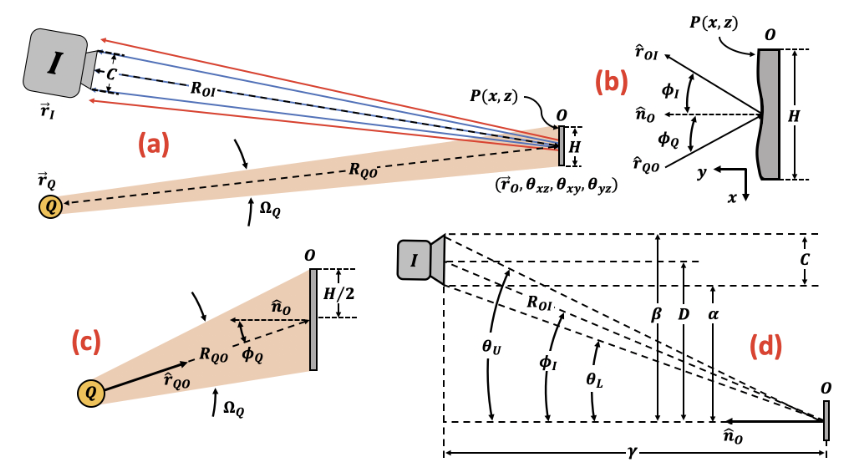

# Import Code Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [ ]:
def findReflectedPropagationVector(incident_propagation_vector, surface_normal):

    #  convention for the surface normal: points into the refracting material
    if(np.linalg.norm(incident_propagation_vector) < 0.9999 or np.linalg.norm(surface_normal) < 0.9999 or np.linalg. norm(incident_propagation_vector) > 1.0001 or np.linalg.norm(surface_normal) > 1.0001):

        print("ERROR: INPUT VECTORS MUST BE UNIT VECTORS!")
        return -1

    else:

        A = np.dot(incident_propagation_vector, surface_normal)

        reflected_propagation_vector = incident_propagation_vector - (surface_normal*(2*A))

        if (np.linalg.norm(reflected_propagation_vector) < 0.9999 or np.linalg.norm(reflected_propagation_vector) > 1.0001):

            print("WOAH! YOUR REFLECTED PROPAGATION VECTOR ISN'T UNIT MAGNITUDE!")
            return -1

        else:

            return reflected_propagation_vector

In [ ]:
def generateKin_xyplane(angle_from_neg_y):

    # angle_from_neg_y ----> CCW is positive

    b = (90 - angle_from_neg_y) # angle in degrees from +y axis

    x_component = np.cos(b * (np.pi/180))
    y_component = -1*np.sqrt(1 - np.square(x_component))

    k_in = np.array([x_component, y_component])

    k_in = k_in / np.linalg.norm(k_in)

    return k_in

# Define Surfaces and Choose One For Simulation

In [ ]:
number_of_spatial_sampling_points = 4096*2
lower_domain = -17.5 #mm
upper_domain = 17.5 #mm
domain = np.linspace(lower_domain, upper_domain, number_of_spatial_sampling_points)

surface_family = "P2"

if (surface_family == "P1"): surface = 0.01*( (1/np.square(17.5))*np.power(domain,4) - np.power(domain,2))
elif (surface_family == "P2"): surface = 0.00003*( (1/np.square(17.5))*np.power(domain,6) - np.power(domain,4))

# Define the 2D Forward Model Function

In [ ]:
def forwardModel2D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, plotting):

    '''
    Calculate V_i for a single system geometry
    Essentially tells us: how much (if any) signal will we see from some surface given an illumination angle and an observation angle
    Map will specifically tell *which* points on the surface we will detect

    If you want to see the step-by-step plot, turn on plotting
    If you want it to just calculate, turn plotting off

    '''

    # if you want to plot the steps of the simulation, set up some plotting parameters
    if (plotting == True):

        fig, axs = plt.subplots(3, 3, figsize = (10,10), layout="constrained")

        sizeofreddots = 10
        howmanyarrows = 20
        scale_of_arrows = 0.4
        xtickfrequ = 7

    # get the gradient of the surface
    dPdx = np.gradient(surface, np.abs(domain[1] - domain[0]))

    tangent_vectors = []
    normal_vectors = []

    # for every point on the surface, get the tangent and normal vector
    for i in range(0, len(dPdx)):

        gradient = dPdx[i]

        tangent_vector = np.array([1, gradient])
        tangent_vector = tangent_vector / np.linalg.norm(tangent_vector)
        tangent_vectors.append(tangent_vector)

        normal_vector = np.dot(np.array([[0, -1], [1, 0]]), tangent_vector)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        normal_vectors.append(normal_vector)

    # define the observation vector
    obs_vector_x = -1*np.tan(observation_angle * (np.pi/180))
    obs_vector_y = np.cos(observation_angle * (np.pi/180))
    obs_vector_base = [obs_vector_x, obs_vector_y]
    obs_vector_base = obs_vector_base / np.linalg.norm(obs_vector_base)
    obs_vector_head = [0,0]

    # generate the input illumination angle
    input_k = generateKin_xyplane(illumination_angle)

    # calculate system geometry parameters (define special case for on-axis observation angle)
    if (observation_angle == 0):

        D = distance_from_obs_to_obj * np.sin(observation_angle * (np.pi/180))
        alpha = D - (aperture_size/2)
        beta = D + (aperture_size/2)
        gamma = distance_from_obs_to_obj
        theta_L = np.arctan(alpha/gamma)
        theta_U = np.arctan(beta/gamma)
        theta_L = theta_L * (180/np.pi)
        theta_U = theta_U * (180/np.pi)


    # calculate system geometry parameters - see paper figure for drawing
    else:

        D = distance_from_obs_to_obj * np.sin(observation_angle * (np.pi/180))
        alpha = D - (aperture_size/2)
        beta = D + (aperture_size/2)
        gamma = D / np.tan(observation_angle * (np.pi/180))
        theta_L = np.arctan(alpha/gamma)
        theta_U = np.arctan(beta/gamma)
        theta_L = theta_L * (180/np.pi)
        theta_U = theta_U * (180/np.pi)


    reflected_vectors = []
    reflected_angles_degrees = []
    signal_vector_map = []

    # for each point on the surface --- (this loop will generate the signal vector for this single system geometry)
    for i in range(0, number_of_spatial_sampling_points):

        # get the reflected vector at that point
        normalvector = normal_vectors[i]
        R = findReflectedPropagationVector(input_k, normalvector)
        R_x_component = R[0]
        reflected_vectors.append(R)

        reflected_angle_radians = np.arccos(np.dot(np.array([0, 1]), R))
        reflected_angle_degrees = reflected_angle_radians * (180/np.pi)

        if (R_x_component < 0): reflected_angle_degrees = -1 * reflected_angle_degrees

        reflected_angle_degrees = -1 * reflected_angle_degrees # make coordinate system agree
        reflected_angles_degrees.append(reflected_angle_degrees)

        # if the reflected angle is within our observation acceptance cone
        if (reflected_angle_degrees <= theta_U and reflected_angle_degrees >= theta_L):

            # receive a signal
            signal_vector_map.append(1)
            if (plotting == True): axs[1,2].scatter(domain[i], surface[i], sizeofreddots, color = 'red')

        # if not
        else:

            # don't recieve a signal
            signal_vector_map.append(0)

    # total signal at this system geometry is sum of all the signals from the surface at that geometry
    # essentailly tells us how many rays we've captured
    sum_of_signal_vector = np.sum(signal_vector_map)

    # define the amount of energy each ray contains - assume unit magnitude and distrbute equally among all rays
    total_energy = 1
    energy_per_ray = total_energy / number_of_spatial_sampling_points

    V_i = energy_per_ray * sum_of_signal_vector # energy per ray * number of rays we have captured

    # BEGIN PLOTTING STUFF
    if (plotting == True):

        for i in range(0,3):

            for j in range(0, 3):

                axs[i,j].grid()
                axs[i,j].axis('equal')

        surface_string = "Surface in Family $P_2(x)$"
        axs[0,0].set_title(surface_string)
        axs[0,0].plot(domain, surface)
        axs[0,0].set_xlabel('x [mm] (' + str(number_of_spatial_sampling_points) + " sampling points)")
        axs[0,0].set_ylabel('y [mm]')
        axs[0,0].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))
        axs[0,0].set_ylim([-3, 3])

        axs[0,1].set_title("b) Gradient of Surface")
        axs[0,1].plot(domain, dPdx)
        axs[0,1].set_xlabel('x [mm]')
        #axs[0,1].set_yticklabels([])
        axs[0,1].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))
        axs[0,1].axis('auto')

        for q in np.arange(0, number_of_spatial_sampling_points, int(number_of_spatial_sampling_points/howmanyarrows)):

            xloc = domain[q]
            yloc = surface[q]

            axs[0,2].quiver(xloc, yloc,tangent_vectors[q][0], tangent_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')
            axs[1,0].quiver(xloc, yloc,normal_vectors[q][0], normal_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')
            axs[1,2].quiver(xloc, yloc,reflected_vectors[q][0], reflected_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')

        axs[0,2].set_title("c) Surface with Tangent Vectors")
        axs[0,2].plot(domain, surface)
        axs[0,2].set_xlabel('x [mm]')
        axs[0,2].set_yticklabels([])
        axs[0,2].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

        axs[1,0].set_title("d) Surface with Normal Vectors")
        axs[1,0].plot(domain, surface)
        axs[1,0].set_xlabel('x [mm]')
        axs[1,0].set_yticklabels([])
        axs[1,0].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

        axs[1,1].set_title("e) Illum. Angle: " + str(np.round(illumination_angle,1)) + " deg wrt -y")
        axs[1,1].set_xlim([-1.3, 1.3])
        axs[1,1].set_ylim([-1.3, 1.3])
        axs[1,1].quiver(input_k[0], input_k[1],angles='xy', scale=1, scale_units='xy', color='black')
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        axs[1,1].axhline(y=0, color='k', alpha = 0.5)
        axs[1,1].axvline(x=0, color='k', alpha = 0.5)
        axs[1,1].set_xlabel("CCW is +")
        axs[1,1].set_ylabel("--> is +y")

        axs[1,2].set_title("f) Surface with Reflected Vectors")
        axs[1,2].plot(domain, surface)
        axs[1,2].set_xlabel('x [mm]')
        axs[1,2].set_yticklabels([])
        axs[1,2].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))
        axs[1,2].text(-14, -9.75, "red dots indicate \n detected-signal points", color = 'red', fontsize = 10)
        axs[1,2].set_ylabel("--> is +y")

        axs[2,0].set_title("g) Reflected Angles wrt +y")
        axs[2,0].axis('auto')
        axs[2,0].set_ylim([np.min(reflected_angles_degrees)-3, np.max(reflected_angles_degrees)+3])
        axs[2,0].set_ylabel("Degrees (CCW is +)")
        axs[2,0].plot(domain, reflected_angles_degrees)
        axs[2,0].hlines(observation_angle, np.min(domain), np.max(domain), color = 'red', linestyle = 'dashed')
        reflected_angle_range = np.abs(np.max(reflected_angles_degrees)-np.min(reflected_angles_degrees))
        qq = reflected_angle_range * 0.1
        axs[2,0].text(-12.5, np.max(reflected_angles_degrees)-(1*qq), "--- observation angle: " + str(observation_angle) + " deg", color = 'red', fontsize = 8)
        axs[2,0].text(-12.5, np.max(reflected_angles_degrees)-(2*qq), "lower collection angle: " + str(np.round(theta_L, 2)) + " deg", color = 'red', fontsize = 8)
        axs[2,0].text(-12.5, np.max(reflected_angles_degrees)-(3*qq), "upper collection angle: " + str(np.round(theta_U, 2)) + " deg", color = 'red', fontsize = 8)
        axs[2,0].fill_between(x=domain, y1=theta_U, y2=theta_L, color='red',  interpolate=False, alpha=.2)
        axs[2,0].set_xlabel('x [mm]')
        axs[2,0].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

        axs[2,1].set_title("(h) Obs. Angle: " + str(np.round(observation_angle,2)) + " deg wrt +y")
        axs[2,1].set_xticks([])
        axs[2,1].set_yticks([])
        axs[2,1].axhline(y=0, color='k', alpha = 0.5)
        axs[2,1].axvline(x=0, color='k', alpha = 0.5)
        axs[2,1].set_xlim([-1.3, 1.3])
        axs[2,1].set_ylim([-1.3, 1.3])
        axs[2,1].quiver(0+obs_vector_base[0], 0+obs_vector_base[1], -1*obs_vector_base[0], -1*obs_vector_base[1], angles='xy', scale=1, scale_units='xy', color='black')
        axs[2,1].scatter(obs_vector_base[0], obs_vector_base[1], color = 'red')
        axs[2,1].text(-1.1, -0.57, "diameter of aperture: " + str(aperture_size) + " mm", color = 'black', fontsize = 9)
        axs[2,1].text(-1.1, -0.7, "distance from obj to imager: " + str(distance_from_obs_to_obj) + " mm", color = 'black', fontsize = 9)
        axs[2,1].set_xlabel("CCW is +")
        axs[2,1].set_ylabel("--> is +y")

        axs[2,2].set_title("i) Signal Map (" + "$V_i = $" + str(np.round(V_i,3)) + ")")
        axs[2,2].axis('auto')
        axs[2,2].set_ylim([-0.1, 1.1])
        axs[2,2].plot(domain, signal_vector_map)
        axs[2,2].set_xlabel('x [mm]')
        axs[2,2].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

    return V_i

In [ ]:
# define temp function to return reflected angle array instead of V_i

def tempForwardModel2D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, plotting):

    # if you want to plot the steps of the simulation, set up some plotting parameters
    if (plotting == True):

        fig, axs = plt.subplots(3, 3, figsize = (10,10), layout="constrained")

        sizeofreddots = 10
        howmanyarrows = 20
        scale_of_arrows = 0.4
        xtickfrequ = 7

    # get the gradient of the surface
    dPdx = np.gradient(surface, np.abs(domain[1] - domain[0]))

    tangent_vectors = []
    normal_vectors = []

    # for every point on the surface, get the tangent and normal vector
    for i in range(0, len(dPdx)):

        gradient = dPdx[i]

        tangent_vector = np.array([1, gradient])
        tangent_vector = tangent_vector / np.linalg.norm(tangent_vector)
        tangent_vectors.append(tangent_vector)

        normal_vector = np.dot(np.array([[0, -1], [1, 0]]), tangent_vector)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        normal_vectors.append(normal_vector)

    # define the observation vector
    obs_vector_x = -1*np.tan(observation_angle * (np.pi/180))
    obs_vector_y = np.cos(observation_angle * (np.pi/180))
    obs_vector_base = [obs_vector_x, obs_vector_y]
    obs_vector_base = obs_vector_base / np.linalg.norm(obs_vector_base)
    obs_vector_head = [0,0]

    # generate the input illumination angle
    input_k = generateKin_xyplane(illumination_angle)

    # calculate system geometry parameters (define special case for on-axis observation angle)
    if (observation_angle == 0):

        D = distance_from_obs_to_obj * np.sin(observation_angle * (np.pi/180))
        alpha = D - (aperture_size/2)
        beta = D + (aperture_size/2)
        gamma = distance_from_obs_to_obj
        theta_L = np.arctan(alpha/gamma)
        theta_U = np.arctan(beta/gamma)
        theta_L = theta_L * (180/np.pi)
        theta_U = theta_U * (180/np.pi)


    # calculate system geometry parameters - see paper figure for drawing
    else:

        D = distance_from_obs_to_obj * np.sin(observation_angle * (np.pi/180))
        alpha = D - (aperture_size/2)
        beta = D + (aperture_size/2)
        gamma = D / np.tan(observation_angle * (np.pi/180))
        theta_L = np.arctan(alpha/gamma)
        theta_U = np.arctan(beta/gamma)
        theta_L = theta_L * (180/np.pi)
        theta_U = theta_U * (180/np.pi)


    reflected_vectors = []
    reflected_angles_degrees = []
    signal_vector_map = []

    # for each point on the surface --- (this loop will generate the signal vector for this single system geometry)
    for i in range(0, number_of_spatial_sampling_points):

        # get the reflected vector at that point
        normalvector = normal_vectors[i]
        R = findReflectedPropagationVector(input_k, normalvector)
        R_x_component = R[0]
        reflected_vectors.append(R)

        reflected_angle_radians = np.arccos(np.dot(np.array([0, 1]), R))
        reflected_angle_degrees = reflected_angle_radians * (180/np.pi)

        if (R_x_component < 0): reflected_angle_degrees = -1 * reflected_angle_degrees

        reflected_angle_degrees = -1 * reflected_angle_degrees # make coordinate system agree
        reflected_angles_degrees.append(reflected_angle_degrees)

        # if the reflected angle is within our observation acceptance cone
        if (reflected_angle_degrees <= theta_U and reflected_angle_degrees >= theta_L):

            # receive a signal
            signal_vector_map.append(1)
            if (plotting == True): axs[1,2].scatter(domain[i], surface[i], sizeofreddots, color = 'red')

        # if not
        else:

            # don't recieve a signal
            signal_vector_map.append(0)

    # total signal at this system geometry is sum of all the signals from the surface at that geometry
    # essentailly tells us how many rays we've captured
    sum_of_signal_vector = np.sum(signal_vector_map)

    # define the amount of energy each ray contains - assume unit magnitude and distrbute equally among all rays
    total_energy = 1
    energy_per_ray = total_energy / number_of_spatial_sampling_points

    V_i = energy_per_ray * sum_of_signal_vector # energy per ray * number of rays we have captured

    # BEGIN PLOTTING STUFF
    if (plotting == True):

        for i in range(0,3):

            for j in range(0, 3):

                axs[i,j].grid()
                axs[i,j].axis('equal')

        surface_string = "Surface in Family $P_2(x)$"
        axs[0,0].set_title(surface_string)
        axs[0,0].plot(domain, surface)
        axs[0,0].set_xlabel('x [mm] (' + str(number_of_spatial_sampling_points) + " sampling points)")
        axs[0,0].set_ylabel('y [mm]')
        axs[0,0].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))
        axs[0,0].set_ylim([-3, 3])

        axs[0,1].set_title("b) Gradient of Surface")
        axs[0,1].plot(domain, dPdx)
        axs[0,1].set_xlabel('x [mm]')
        #axs[0,1].set_yticklabels([])
        axs[0,1].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))
        axs[0,1].axis('auto')

        for q in np.arange(0, number_of_spatial_sampling_points, int(number_of_spatial_sampling_points/howmanyarrows)):

            xloc = domain[q]
            yloc = surface[q]

            axs[0,2].quiver(xloc, yloc,tangent_vectors[q][0], tangent_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')
            axs[1,0].quiver(xloc, yloc,normal_vectors[q][0], normal_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')
            axs[1,2].quiver(xloc, yloc,reflected_vectors[q][0], reflected_vectors[q][1],angles='xy', scale=scale_of_arrows, scale_units='xy', color='black')

        axs[0,2].set_title("c) Surface with Tangent Vectors")
        axs[0,2].plot(domain, surface)
        axs[0,2].set_xlabel('x [mm]')
        axs[0,2].set_yticklabels([])
        axs[0,2].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

        axs[1,0].set_title("d) Surface with Normal Vectors")
        axs[1,0].plot(domain, surface)
        axs[1,0].set_xlabel('x [mm]')
        axs[1,0].set_yticklabels([])
        axs[1,0].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

        axs[1,1].set_title("e) Illum. Angle: " + str(np.round(illumination_angle,1)) + " deg wrt -y")
        axs[1,1].set_xlim([-1.3, 1.3])
        axs[1,1].set_ylim([-1.3, 1.3])
        axs[1,1].quiver(input_k[0], input_k[1],angles='xy', scale=1, scale_units='xy', color='black')
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        axs[1,1].axhline(y=0, color='k', alpha = 0.5)
        axs[1,1].axvline(x=0, color='k', alpha = 0.5)
        axs[1,1].set_xlabel("CCW is +")
        axs[1,1].set_ylabel("--> is +y")

        axs[1,2].set_title("f) Surface with Reflected Vectors")
        axs[1,2].plot(domain, surface)
        axs[1,2].set_xlabel('x [mm]')
        axs[1,2].set_yticklabels([])
        axs[1,2].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))
        axs[1,2].text(-14, -9.75, "red dots indicate \n detected-signal points", color = 'red', fontsize = 10)
        axs[1,2].set_ylabel("--> is +y")

        axs[2,0].set_title("g) Reflected Angles wrt +y")
        axs[2,0].axis('auto')
        axs[2,0].set_ylim([np.min(reflected_angles_degrees)-3, np.max(reflected_angles_degrees)+3])
        axs[2,0].set_ylabel("Degrees (CCW is +)")
        axs[2,0].plot(domain, reflected_angles_degrees)
        axs[2,0].hlines(observation_angle, np.min(domain), np.max(domain), color = 'red', linestyle = 'dashed')
        reflected_angle_range = np.abs(np.max(reflected_angles_degrees)-np.min(reflected_angles_degrees))
        qq = reflected_angle_range * 0.1
        axs[2,0].text(-12.5, np.max(reflected_angles_degrees)-(1*qq), "--- observation angle: " + str(observation_angle) + " deg", color = 'red', fontsize = 8)
        axs[2,0].text(-12.5, np.max(reflected_angles_degrees)-(2*qq), "lower collection angle: " + str(np.round(theta_L, 2)) + " deg", color = 'red', fontsize = 8)
        axs[2,0].text(-12.5, np.max(reflected_angles_degrees)-(3*qq), "upper collection angle: " + str(np.round(theta_U, 2)) + " deg", color = 'red', fontsize = 8)
        axs[2,0].fill_between(x=domain, y1=theta_U, y2=theta_L, color='red',  interpolate=False, alpha=.2)
        axs[2,0].set_xlabel('x [mm]')
        axs[2,0].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

        axs[2,1].set_title("(h) Obs. Angle: " + str(np.round(observation_angle,2)) + " deg wrt +y")
        axs[2,1].set_xticks([])
        axs[2,1].set_yticks([])
        axs[2,1].axhline(y=0, color='k', alpha = 0.5)
        axs[2,1].axvline(x=0, color='k', alpha = 0.5)
        axs[2,1].set_xlim([-1.3, 1.3])
        axs[2,1].set_ylim([-1.3, 1.3])
        axs[2,1].quiver(0+obs_vector_base[0], 0+obs_vector_base[1], -1*obs_vector_base[0], -1*obs_vector_base[1], angles='xy', scale=1, scale_units='xy', color='black')
        axs[2,1].scatter(obs_vector_base[0], obs_vector_base[1], color = 'red')
        axs[2,1].text(-1.1, -0.57, "diameter of aperture: " + str(aperture_size) + " mm", color = 'black', fontsize = 9)
        axs[2,1].text(-1.1, -0.7, "distance from obj to imager: " + str(distance_from_obs_to_obj) + " mm", color = 'black', fontsize = 9)
        axs[2,1].set_xlabel("CCW is +")
        axs[2,1].set_ylabel("--> is +y")

        axs[2,2].set_title("i) Signal Map (" + "$V_i = $" + str(np.round(V_i,3)) + ")")
        axs[2,2].axis('auto')
        axs[2,2].set_ylim([-0.1, 1.1])
        axs[2,2].plot(domain, signal_vector_map)
        axs[2,2].set_xlabel('x [mm]')
        axs[2,2].set_xticks(np.arange(np.min(domain), np.max(domain)+1, xtickfrequ))

    return reflected_angles_degrees

# Define Other System Parameters

In [ ]:
aperture_size = 500 #mm

illumination_angle = 15 #deg (CCW is +, measured from negative y axis)
observation_angle = -15 #deg (CCW is +, measured from positive y axis)

distance_from_obs_to_obj = 3000 #mm

plotting = True

# Run the Static State (Single System Geometry) 2D Forward Model - Generate $V_i$

A note on the interpretation of the value $V_i$ which is returned: <br>

We unit-normalize the energy leaving the surface.<br>
This energy is distributed among all of the rays.<br>
We distribute this among "number_of_spatial_sampling_points" number of rays.<br>
This gives us an energy per ray metric.<br>

Then, $V_i$ is calculated by multiplying the energy per ray metric by the number of rays collected.<br>
So in this way, $V_i$ is representative of the amount of energy collected by the system.<br>

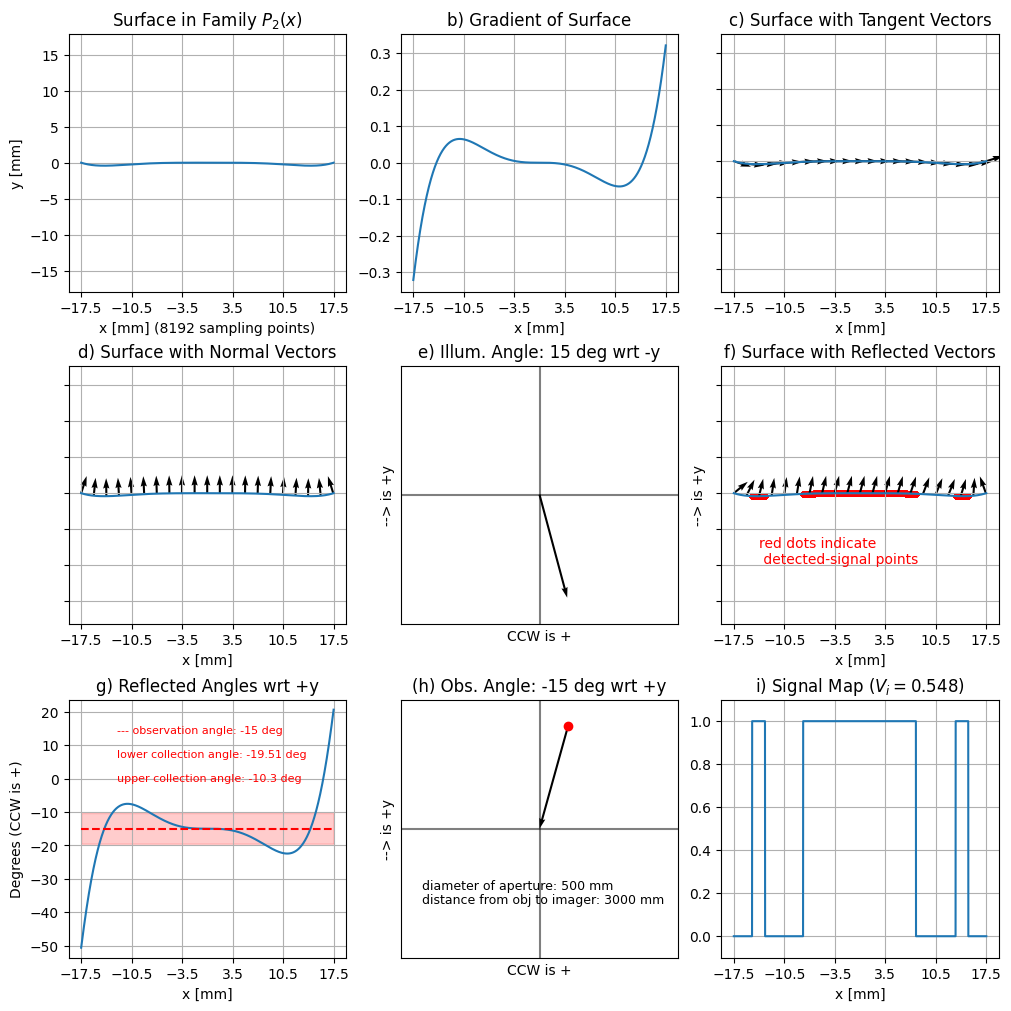

In [ ]:
forwardModel2D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, plotting);

# Run the Dynamic Forward Model to Assemble Signal Vector $S_G$

We choose to make the system dynamic by sweeping over a range of observation angles. <br>
Each new observation angle is a new system geometry $g_i$. <br>
We assume that each system geometry is sampled for only one unit of time.

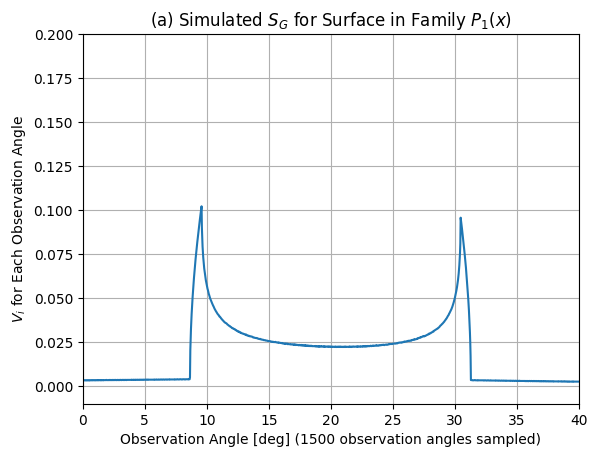

In [ ]:
number_of_observation_angles = 1500
start_angle = 0
end_angle = 40
observation_angles = np.linspace(start_angle, end_angle, number_of_observation_angles)

illumination_angle = -20 #deg (CCW is +, measured from negative y axis)
aperture_size = 50 #mm
distance_from_obs_to_obj = 3000 #mm


S_G = []

for o in range(0, number_of_observation_angles):

    observation_angle = observation_angles[o]

    V_i = forwardModel2D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)

    S_G.append(V_i)

fig2, ax = plt.subplots(1,1)
ax.plot(observation_angles, S_G)
ax.set_xlim([start_angle, end_angle])
ax.set_ylim([-0.01, 0.2])
ax.grid()
ax.set_xlabel("Observation Angle [deg] (" + str(number_of_observation_angles) + " observation angles sampled)")
ax.set_ylabel("$V_i$ for Each Observation Angle")
titlestr = "(a) Simulated $S_G$ for Surface in Family $P_1(x)$"
ax.set_title(titlestr);

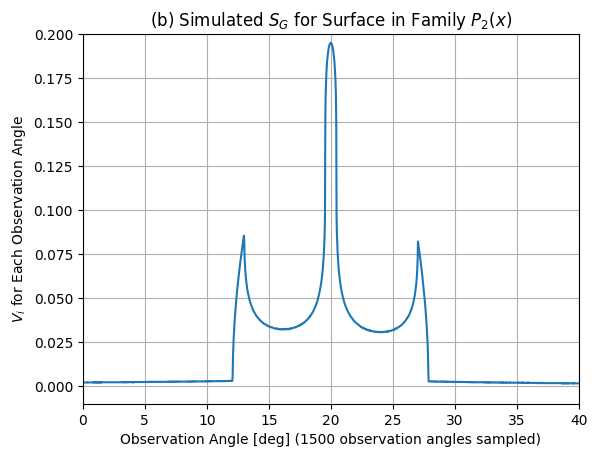

In [ ]:
number_of_observation_angles = 1500
start_angle = 0
end_angle = 40
observation_angles = np.linspace(start_angle, end_angle, number_of_observation_angles)

illumination_angle = -20 #deg (CCW is +, measured from negative y axis)
aperture_size = 50 #mm
distance_from_obs_to_obj = 3000 #mm


S_G = []

for o in range(0, number_of_observation_angles):

    observation_angle = observation_angles[o]

    V_i = forwardModel1D(number_of_spatial_sampling_points, domain, surface, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)

    S_G.append(V_i)

fig2, ax = plt.subplots(1,1)
ax.plot(observation_angles, S_G)
ax.set_xlim([start_angle, end_angle])
ax.set_ylim([-0.01, 0.2])
ax.grid()
ax.set_xlabel("Observation Angle [deg] (" + str(number_of_observation_angles) + " observation angles sampled)")
ax.set_ylabel("$V_i$ for Each Observation Angle")
titlestr = "(b) Simulated $S_G$ for Surface in Family $P_2(x)$"
ax.set_title(titlestr);

# Make Figure for Paper

In [ ]:
number_of_spatial_sampling_points = 4096*2
lower_domain = -17.5 #mm
upper_domain = 17.5 #mm
domain = np.linspace(lower_domain, upper_domain, number_of_spatial_sampling_points)

surface1 = 0.01*( (1/np.square(17.5))*np.power(domain,4) - np.power(domain,2))
surface2 = 0.00003*( (1/np.square(17.5))*np.power(domain,6) - np.power(domain,4))
surface3 = -1*surface1 + np.min(surface1)
surface4 = 7*np.sin(0.3*domain)*0.01*domain

surfaces = [surface1, surface2, surface3, surface4]

In [ ]:
aperture_size = 50 #mm

illumination_angle = 0 #deg (CCW is +, measured from negative y axis)

distance_from_obs_to_obj = 3000 #mm

In [ ]:
surface1reflectedangles = tempForwardModel2D(number_of_spatial_sampling_points, domain, surface1, 50, illumination_angle, 0, 3000, False)
surface2reflectedangles = tempForwardModel2D(number_of_spatial_sampling_points, domain, surface2, 50, illumination_angle, 0, 3000, False)
surface3reflectedangles = tempForwardModel2D(number_of_spatial_sampling_points, domain, surface3, 50, illumination_angle, 0, 3000, False)
surface4reflectedangles = tempForwardModel2D(number_of_spatial_sampling_points, domain, surface4, 50, illumination_angle, 0, 3000, False)

reflected_angle_curves = [surface1reflectedangles, surface2reflectedangles, surface3reflectedangles, surface4reflectedangles]

In [ ]:
number_of_observation_angles = 2000
start_angle = -40
end_angle = 40
observation_angles = np.linspace(start_angle, end_angle, number_of_observation_angles)

illumination_angle = 0 #deg (CCW is +, measured from negative y axis)
aperture_size = 50 #mm
distance_from_obs_to_obj = 3000 #mm


surface1_S_G = []
surface2_S_G = []
surface3_S_G = []
surface4_S_G = []

for o in range(0, number_of_observation_angles):

    observation_angle = observation_angles[o]

    V_i_surface1 = forwardModel2D(number_of_spatial_sampling_points, domain, surface1, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)
    V_i_surface2 = forwardModel2D(number_of_spatial_sampling_points, domain, surface2, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)
    V_i_surface3 = forwardModel2D(number_of_spatial_sampling_points, domain, surface3, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)
    V_i_surface4 = forwardModel2D(number_of_spatial_sampling_points, domain, surface4, aperture_size, illumination_angle, observation_angle, distance_from_obs_to_obj, False)

    surface1_S_G.append(V_i_surface1)
    surface2_S_G.append(V_i_surface2)
    surface3_S_G.append(V_i_surface3)
    surface4_S_G.append(V_i_surface4)

    print("observation angle finished:", o)

S_G_curves = [surface1_S_G, surface2_S_G, surface3_S_G, surface4_S_G]

observation angle finished: 0
observation angle finished: 1
observation angle finished: 2
observation angle finished: 3
observation angle finished: 4
observation angle finished: 5
observation angle finished: 6
observation angle finished: 7
observation angle finished: 8
observation angle finished: 9
observation angle finished: 10
observation angle finished: 11
observation angle finished: 12
observation angle finished: 13
observation angle finished: 14
observation angle finished: 15
observation angle finished: 16
observation angle finished: 17
observation angle finished: 18
observation angle finished: 19
observation angle finished: 20
observation angle finished: 21
observation angle finished: 22
observation angle finished: 23
observation angle finished: 24
observation angle finished: 25
observation angle finished: 26
observation angle finished: 27
observation angle finished: 28
observation angle finished: 29
observation angle finished: 30
observation angle finished: 31
observation angle 

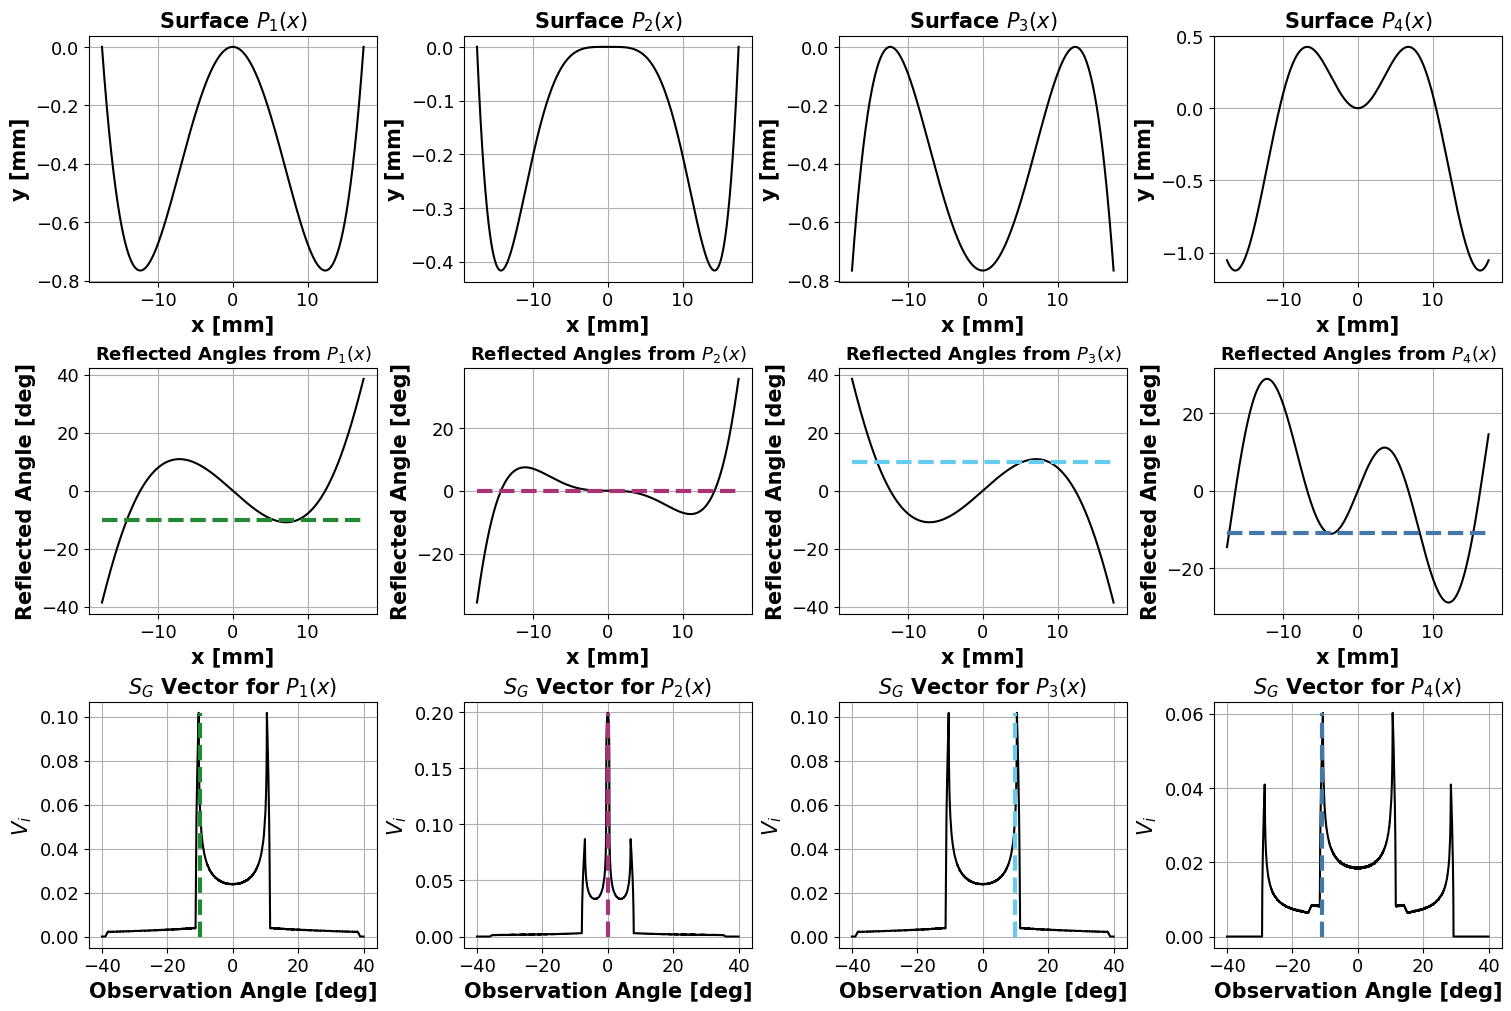

In [ ]:
fig, axs = plt.subplots(3, 4, figsize = (15,10), layout = 'constrained')

surface_titles = ["Surface $P_1(x)$", "Surface $P_2(x)$", "Surface $P_3(x)$", "Surface $P_4(x)$"]
reflected_angle_titles = ["Reflected Angles from $P_1(x)$", "Reflected Angles from $P_2(x)$", "Reflected Angles from $P_3(x)$", "Reflected Angles from $P_4(x)$"]
S_G_titles = ["$S_G$ Vector for $P_1(x)$", "$S_G$ Vector for $P_2(x)$", "$S_G$ Vector for $P_3(x)$", "$S_G$ Vector for $P_4(x)$"]
linecolors = ["#228833", "#AA3377", "#66CCEE", "#4477AA"]

dashedanglelines = [-10, 0, 10, -11]

for c in range(0,4):

    axs[0,c].plot(domain, surfaces[c], color = 'k')
    axs[1,c].plot(domain, reflected_angle_curves[c], color = 'k')
    axs[2,c].plot(observation_angles, S_G_curves[c], color = 'k')

    axs[0,c].set_title(surface_titles[c], fontweight = 'bold', fontsize = 15)
    axs[1,c].set_title(reflected_angle_titles[c], fontweight = 'bold', fontsize = 13)
    axs[2,c].set_title(S_G_titles[c], fontweight = 'bold', fontsize = 15)

    axs[0,c].grid()
    axs[1,c].grid()
    axs[2,c].grid()

    axs[0,c].set_xlabel("x [mm]", fontweight = 'bold', fontsize = 15)
    axs[1,c].set_xlabel("x [mm]", fontweight = 'bold', fontsize = 15)
    axs[2,c].set_xlabel("Observation Angle [deg]", fontweight = 'bold', fontsize = 15)

    axs[0,c].tick_params(axis='both', which='major', labelsize=13)
    axs[1,c].tick_params(axis='both', which='major', labelsize=13)
    axs[2,c].tick_params(axis='both', which='major', labelsize=13)

    axs[0,c].set_ylabel("y [mm]", fontweight = 'bold', fontsize = 15)
    axs[1,c].set_ylabel("Reflected Angle [deg]", fontweight = 'bold', fontsize = 15)
    axs[2,c].set_ylabel("$V_i$", fontweight = 'bold', fontsize = 15)

    axs[1,c].hlines(dashedanglelines[c], np.min(domain), np.max(domain), color = linecolors[c], linestyle = 'dashed', linewidth = 3)

    axs[2,c].vlines(dashedanglelines[c], 0, np.max(S_G_curves[c]), color = linecolors[c], linestyle = 'dashed', linewidth = 3)